In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
#from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn
import my_plot_style as mps
mps.my_plot_style()

In [91]:
#test = Table.read(directory+'zpix-sv1-dark.fits')

In [92]:
def matching_pernight_cumulative_VI_data(pernight_data,cumulative_data,target_name):
    if target_name=='BGS':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
        dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
    
    elif target_name=='LRG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
        dataname = 'allVItiles_LRGzinfo_wVI.fits'
    
    elif target_name=='ELG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/ELG/'
        dataname = 'allVItiles_ELGzinfo_wVI.fits'
    
    VI_data = Table.read(diretory+dataname)
    VI_data = VI_data[(VI_data['subset']=='deep') & (VI_data['subset']!='All') & ((VI_data['N_VI']>0))]
    VI_data = VI_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                        ,'FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','best_z','best_quality','N_VI','all_VI_comments','merger_comment'].to_pandas()
    
    catalog_match = pernight_dataset.merge(everest_dataset,on='TARGETID',how='left',suffixes=("_pernight","_cumulative"))
    final_match_catalog = catalog_match[catalog_match['TILEID_pernight']==catalog_match['TILEID_cumulative']]
    
    #catalog_match = everest_data.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    #final_match_catalog = catalog_match[catalog_match['TILEID']==catalog_match['TILEID_VI']]

    final_match_catalog = final_match_catalog.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    final_match_catalog = final_match_catalog[final_match_catalog['TILEID_pernight']==final_match_catalog['TILEID']]
    final_match_catalog['dz_pernight_VI'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])

    return final_match_catalog    

In [93]:
directory = '/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/'

In [94]:
#exposure_info = Table.read('/global/cfs/cdirs/desi/spectro/redux/everest/exposures-everest.fits')

In [122]:
pernight_data = Table.read(directory+'ztile-sv1-pernight.fits',1)
everest_all = Table.read(directory+'ztile-sv1-cumulative.fits')
pernight_dataset = pernight_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','COADD_EXPTIME','ZWARN','SPECTYPE'
                              ].to_pandas()
everest_dataset = everest_all['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','COADD_EXPTIME',
                              'FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','SPECTYPE'].to_pandas()

In [123]:
catalog_match = pernight_dataset.merge(everest_dataset,on='TARGETID',how='left',suffixes=("_pernight","_cumulative"))
final_match_catalog = catalog_match[catalog_match['TILEID_pernight']==catalog_match['TILEID_cumulative']]

(array([700074., 553571., 586091., 353716., 290563.,  89333.,  96038.,
         43711.,  71372.,  52031.]),
 array([    0.    ,  2435.931 ,  4871.862 ,  7307.7925,  9743.724 ,
        12179.654 , 14615.585 , 17051.516 , 19487.447 , 21923.377 ,
        24359.309 ], dtype=float32),
 <a list of 10 Patch objects>)

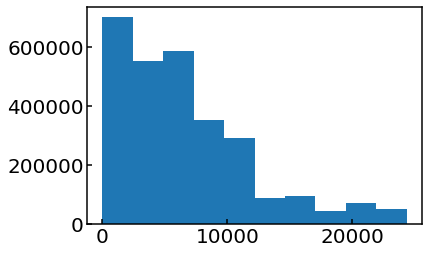

In [124]:
plt.hist(final_match_catalog['COADD_EXPTIME_cumulative'])

In [125]:
cut = ((final_match_catalog['COADD_EXPTIME_pernight']>800) & 
    (final_match_catalog['COADD_EXPTIME_pernight']<1200) & 
    (final_match_catalog['ZWARN_pernight']==0) & (final_match_catalog['ZWARN_cumulative']==0) & 
    (final_match_catalog['DELTACHI2_pernight']>50) &# (final_match_catalog['DELTACHI2_cumulative']>50) & 
    (final_match_catalog['COADD_EXPTIME_cumulative']>4000) & (final_match_catalog['SPECTYPE_pernight']==b'GALAXY'))
final_match_catalog_cut = final_match_catalog[cut]
final_match_catalog_cut['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])
dz_inconsistent = final_match_catalog_cut[final_match_catalog_cut['dz_pernight_cumulative']>=0.0033]
print(len(dz_inconsistent))
print(len(final_match_catalog_cut))



1309
107236


<ipython-input-125-2970a93eb628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog_cut['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])


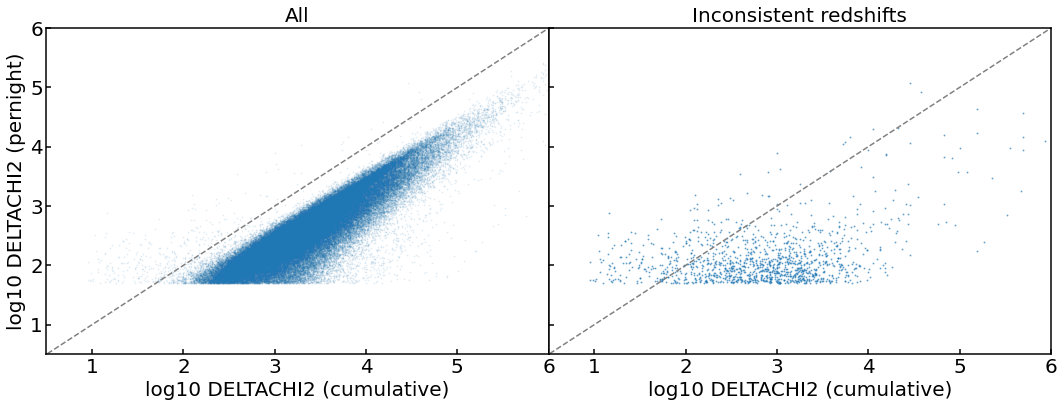

In [126]:
plt.figure(figsize=(18,6))
plt.subplots_adjust(wspace=0.0)
plt.subplot(1,2,1)

plt.scatter(np.log10(final_match_catalog_cut['DELTACHI2_cumulative']),np.log10(final_match_catalog_cut['DELTACHI2_pernight']),s=0.5,alpha=0.1,label='All')
#plt.legend(frameon=False)
plt.title('All')
plt.xlim(0.5,6)
plt.ylim(0.5,6)
plt.ylabel('log10 DELTACHI2 (pernight)',fontsize=20)
plt.xlabel('log10 DELTACHI2 (cumulative)',fontsize=20)
plt.plot(np.arange(0,7),np.arange(0,7),ls='--',color='grey',lw=1.5)
plt.subplot(1,2,2)
plt.scatter(np.log10(dz_inconsistent['DELTACHI2_cumulative']),np.log10(dz_inconsistent['DELTACHI2_pernight']),s=1,alpha=0.5,label='inconsistent redshifts')
plt.title('Inconsistent redshifts')
plt.xlim(0.5,6)
plt.ylim(0.5,6)
plt.plot(np.arange(0,7),np.arange(0,7),ls='--',color='grey',lw=1.5)
plt.xlabel('log10 DELTACHI2 (cumulative)',fontsize=20)
mps.removing_ytick_label()

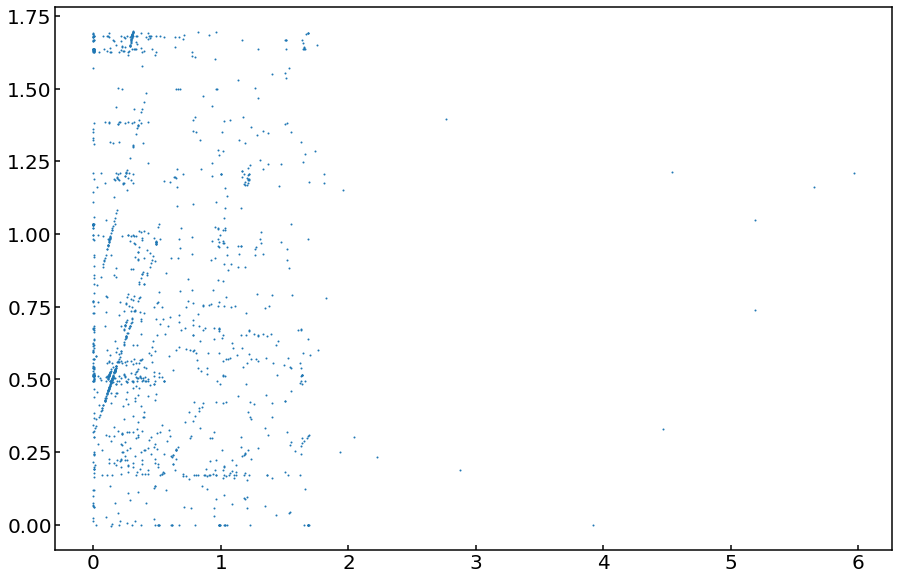

In [127]:
plt.figure(figsize=(15,10))
plt.scatter(dz_inconsistent['Z_cumulative'],dz_inconsistent['Z_pernight'],s=1)

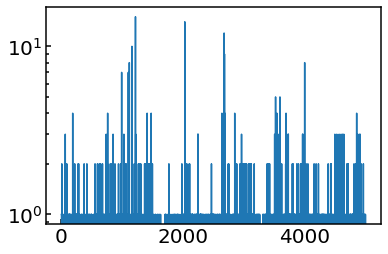

In [128]:
out = np.histogram(dz_inconsistent['FIBER'],range=(-0.5,4999.5),bins=5000)
x = np.arange(0,5000)
y = out[0]
new_x = x[np.argsort(y)][::-1]
new_y = y[np.argsort(y)][::-1]
plt.plot(x,y)
plt.yscale('log')

In [129]:
for i in range(0,30):
    if (new_x[i]<2660) | (new_x[i]>2695):
        print('      %0.0f' % new_x[i])
    else:
        print('%0.0f' % new_x[i])   

      1216
      2026
2672
2666
2670
      1158
2671
2678
2667
      1115
      3995
      1098
      989
2668
      3994
2669
      3589
      3517
      1474
2675
      759
2685
      3590
      185
2663
      1408
      2636
      3689
2674
      2846


In [130]:
len(dz_inconsistent)

1309

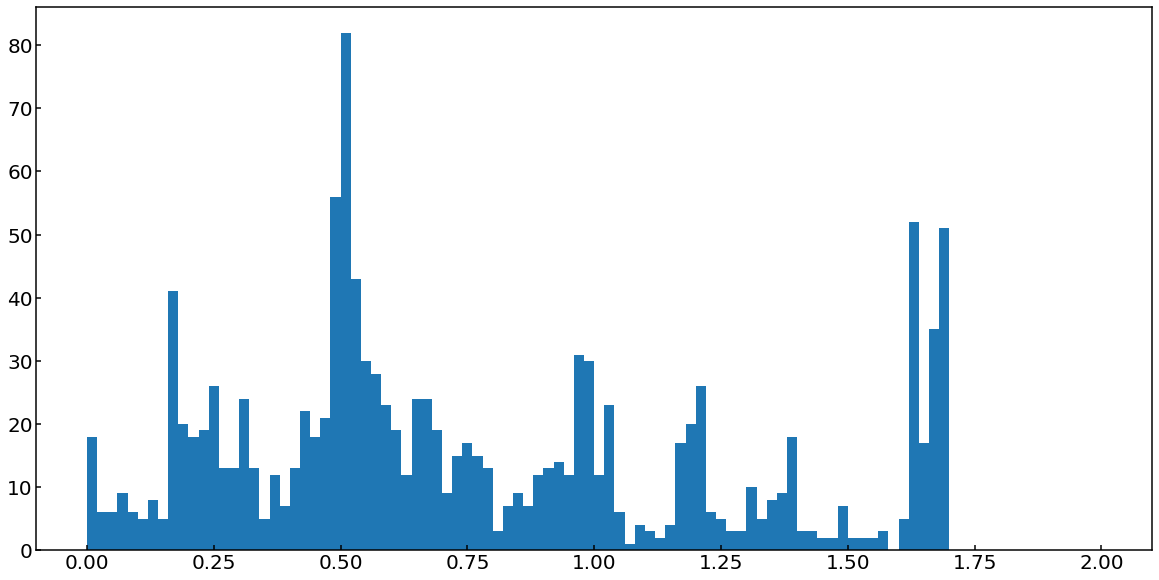

In [136]:
#search = (dz_inconsistent['FIBER']==2026)
plt.figure(figsize=(20,10))
_ = plt.hist(dz_inconsistent['Z_pernight'],bins=100,range=(0,2))

In [84]:
np.sum(new_y[0:500])

1009